In [16]:
import pandas as pd
import matplotlib.pyplot as plt 
import re 
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize


In [14]:
data = pd.read_csv('/Users/merkava/Documents/School/Software engineering/SAS/data/raw/Steam.csv')
data.dropna(inplace=True)

print(data.shape)
print(f"Dataset shape: {data.shape}")



(17316, 5)
Dataset shape: (17316, 5)


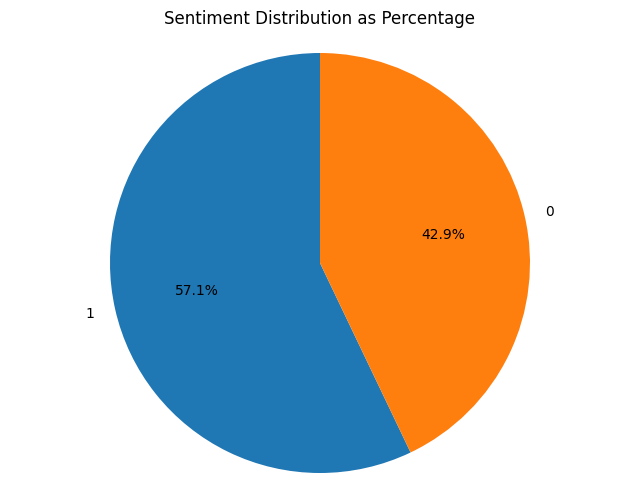

In [4]:
balance = data['user_suggestion'].value_counts()
plt.figure(figsize=(8, 6))
plt.pie(balance, labels=balance.index, autopct='%1.1f%%', startangle=90)
plt.title('Sentiment Distribution as Percentage')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

In [17]:
nltk.download('punkt')
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()
def preprocess_text(text):
        text = text.lower()
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        # Tokenize text
        tokens = word_tokenize(text)
        tokens = [lemmatizer.lemmatize(word) for word in tokens]
        return ' '.join(tokens)


[nltk_data] Downloading package punkt to /Users/merkava/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /Users/merkava/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [18]:
data['cleaned_review'] = data['user_review'].apply(preprocess_text)

# Extract features and target variables
X = data['cleaned_review']
y = data['user_suggestion']  
# Split dataset into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
tfidf = TfidfVectorizer(max_features=5000)  # Adjust max_features as needed
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)